# Case Study 2: Prediction on Diabetes Patients Hospital Readmission

Team Members: 
- Benjamin Goodwin
- Lijju Mathew
- Pradeep Kumar
- Sid Swarupananda



#### Problem Statement
- Hospital Readmission is when a patient who is discharged from the hospital, gets readmitted again within a certain amount of time. Such hospital readmissions are a reflection of the quality of care provided in the hospitals and also result in the high cost of care 
- We are trying to predict the factors for hospital readmission in diabetic patients 

In [1]:
import os
os.chdir('C:/Users/sswarupa/OneDrive - GameStop, Inc/Documents/SMU/QTW/Case Studies/CS2/dataset_diabetes')
import sklearn
import sys, copy
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('diabetic_data.csv')

In [3]:
df.describe(include='all')


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,...,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

The Readmitted column has 3 types of values. They are 'NO" , '>30' and '<30' for no readmission, readmitted after 30 days and readmitted within 30 days respectively. Our goal is to predict readmission with in 30 days. Modify the data to binary data to achieve this objective by considering "NO" and ">30" as 0 and "<30" as 1.

In [5]:
target_col ={'NO':0,
             '>30':0,
             '<30':1}

df['readmitted_binary'] = df['readmitted'].map(target_col)



# Missing Value handling

There are 101766 rows of data. Many of the columns have missing values but none of the missing values are in the format of NaN. The missing values are represented with a ? char in the features. 

In [6]:
df.loc[df['weight']=='?', 'weight'].shape

(98569,)

In [7]:
df.weight.unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

### The Weight column does not have weight in numeric format. When the value is present, it is in string format. Around 96% of the weight column is filled with '?'. Only about 4% of data is valid.

In [8]:
df1 = df.loc[df['weight']=='?', :]

In [9]:
df1.loc[df['admission_source_id']==11].shape[0]

2

In [10]:
df.loc[(df['age']=='[90-100)') & (df['weight']!='?'),'weight'].value_counts()


[50-75)     59
[75-100)    24
[25-50)      9
Name: weight, dtype: int64

### Imputation of weight data. Consider Age as another indicator of weight, lets look at valid weights specific to a age range. Example , in the age range of 10-20, there are 18 valid entries for weight. These 18 entries has only 2 range of weights 25-50 and 50-75. 50-75 weight range is 78% of them. So lets substute all the missing values for age range of 10-20 with weight 50-75. Following this rule, for every age range , the weight range with max count was taken and substituted for missing values.

In [11]:
df.loc[(df['age']=='[10-20)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[0-10)') & (df['weight']=='?'),'weight']='[0-25)'

df.loc[(df['age']=='[20-30)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[30-40)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[40-50)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[50-60)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[60-70)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[70-80)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[80-90)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[90-100)') & (df['weight']=='?'),'weight']='[50-75)'

In [12]:
# The following columns still have missing values.
cols = df.columns

for e in cols:
    c1 = df.loc[df[e]=='?',e]
    if len(c1)>0:
        print('{} {} '.format(e, len(c1)))


race 2273 
payer_code 40256 
medical_specialty 49949 
diag_1 21 
diag_2 358 
diag_3 1423 


In [13]:
df2 = df.loc[df['race']=='?',['age','weight','diabetesMed']]
df2['diabetesMed'].value_counts()
#print(df.loc[df['race']=='?',['race']].shape[0])

Yes    1871
No      402
Name: diabetesMed, dtype: int64

### Imputation of race data. Lets check the distribution of race

Caucasian          58450
AfricanAmerican    14798
Hispanic            1551
Other               1218
Asian                475
Name: race, dtype: int64


<AxesSubplot:>

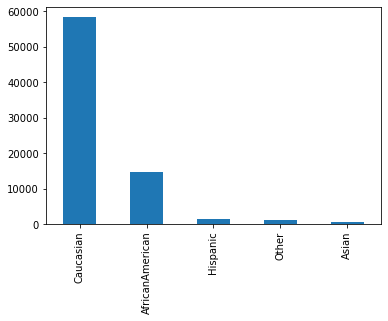

In [14]:
df_race = df.loc[(df['race']!='?') & (df['diabetesMed']=='Yes'),['race','diabetesMed','age']]
by_race = df_race['race'].value_counts()
print(by_race)
by_race.plot.bar()

### Among the 2273 missing race, 1871 (82%) have diabetes.Looking at prevelance of Diabetes , among the 78363 <br> patients with diabetes, 58450 (74%) are from Caucasian race<br> 14798 (18%) are African American <br>. We can fill the 2273 missing race values in the similar ratio. Fill 74%(1682) of them as caucasian and rest of them as African american.  

In [15]:
df.loc[df['diabetesMed']=='Yes'].shape

(78363, 51)

In [16]:
df.loc[df['race']=='?','race'].count()

2273

In [17]:
ind = df.loc[df['race']=='?','race'].index.tolist()
df.iloc[ind[0:1682],df.columns.get_loc('race')]='Caucasian'
df.iloc[ind[1682:],df.columns.get_loc('race')]='AfricanAmerican'


In [18]:
df['medical_specialty'].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

### There are 49949 missing entries in medical_specialty . Lets set these fields as unknown before modeling

In [19]:
df.loc[(df['medical_specialty']=='?'),'medical_specialty']='unknown'

In [20]:
df.medical_specialty.value_counts()

unknown                             49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Proctology                              1
Psychiatry-Addictive                    1
Surgery-PlasticwithinHeadandNeck        1
Neurophysiology                         1
SportsMedicine                          1
Name: medical_specialty, Length: 73, dtype: int64

In [21]:
df['diag_1'].value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
372       1
207       1
988       1
10        1
698       1
Name: diag_1, Length: 717, dtype: int64

In [22]:
def match_val(col_name, match_val):
    return df.loc[df[col_name]==match_val]

In [23]:
#df['medical_specialty'].unique()
for i in df['medical_specialty'].unique():
    if i != '?':
        print(match_val('medical_specialty',i))
        break
        

       encounter_id  patient_nbr             race  gender      age   weight  \
0           2278392      8222157        Caucasian  Female   [0-10)   [0-25)   
216         2735964      2359485        Caucasian  Female   [0-10)   [0-25)   
249         2913624      5073354  AfricanAmerican  Female  [10-20)  [50-75)   
270         2968386      8568180        Caucasian  Female   [0-10)   [0-25)   
277         3039162       539910        Caucasian  Female  [10-20)  [50-75)   
...             ...          ...              ...     ...      ...      ...   
23513      80299218      5128371        Caucasian    Male  [10-20)  [50-75)   
24975      84025056     14711346        Caucasian  Female  [10-20)  [50-75)   
25293      84684900     21276702         Hispanic  Female  [10-20)  [50-75)   
25484      85067952     15264288        Caucasian  Female   [0-10)   [0-25)   
27226      89254374       287640        Caucasian  Female  [10-20)  [50-75)   

       admission_type_id  discharge_disposition_id 

Even though Medical Specialty feature looks like a important feature, it has around 50% of data missing. Do not see a good way to impute this data , so will drop this feature from data before using in the model.
The feature payer_code can also be dropped since it also has many missing values and there is no way to impute the missing data.

In [24]:
#df.drop(columns=['medical_specialty'], inplace=True)
df.drop(columns=['payer_code'], inplace=True)

In [25]:
pd.options.display.max_columns=300

In [26]:
df['diag_3'].value_counts(sort=True)

250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
111         1
215         1
E965        1
853         1
315         1
Name: diag_3, Length: 790, dtype: int64

diag_3 feature has 1423 missing values which are in the form on ?. diag_3 can be considered as categorical feature with 790 unique values. The value 250 has occured 11555 times in the feature which is 11%. Considering this highest occuring value as a substitute for missing values.
A similar strategy will be used for filling missing values for feature diag_1 and diag2 also.

In [27]:
ind = df.loc[df['diag_3']=='?','diag_3'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_3')]='250'
#df.iloc[ind[1682:],df.columns.get_loc('race')]='AfricanAmerican'
df.iloc[ind]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),[0-25),6,25,1,1,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,250,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0
66,715086,3376278,Caucasian,Male,[10-20),[50-75),1,5,7,1,unknown,51,0,4,0,0,0,250.11,?,250,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0
192,2595612,89193870,Caucasian,Female,[40-50),[75-100),6,1,7,2,unknown,53,0,4,0,0,0,250.02,401,250,2,>300,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,0
194,2600796,1451637,Caucasian,Female,[20-30),[50-75),6,25,7,1,Family/GeneralPractice,66,0,6,0,0,0,493,250,250,2,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,0
216,2735964,2359485,Caucasian,Female,[0-10),[0-25),6,25,7,3,Pediatrics-Endocrinology,34,0,4,0,0,0,250.03,?,250,1,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101173,436076462,117223475,AfricanAmerican,Female,[30-40),[75-100),3,1,1,3,ObstetricsandGynecology,22,1,6,0,0,0,220,250,250,2,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101278,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,Surgery-General,54,4,14,1,0,0,552,250,250,2,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101474,439709132,109758042,Hispanic,Male,[50-60),[75-100),2,1,7,1,Surgery-General,4,3,7,0,1,0,786,250,250,2,None,Norm,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101560,440879552,42751098,Caucasian,Female,[60-70),[75-100),3,1,1,5,Nephrology,42,1,15,0,0,0,590,276,250,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0


In [28]:
df['diag_1'].value_counts(sort=True)

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
372       1
207       1
988       1
10        1
698       1
Name: diag_1, Length: 717, dtype: int64

In [29]:
# The value 428 is prominent in case of diag_1 feature. This value will be used to replace the missing values
ind = df.loc[df['diag_1']=='?','diag_1'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_1')]='428'
#df.iloc[ind]

In [30]:
df['diag_2'].value_counts(sort=True)

276     6752
428     6662
250     6071
427     5036
401     3736
        ... 
E980       1
683        1
137        1
E883       1
460        1
Name: diag_2, Length: 749, dtype: int64

In [31]:
# The value 276 is prominent in case of diag_2 feature. This value will be used to replace the missing values
ind = df.loc[df['diag_2']=='?','diag_2'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_2')]='276'
#df.iloc[ind]

In [32]:
df.loc[df['diag_3']=='?','diag_3']

Series([], Name: diag_3, dtype: object)

In [33]:
# Check for any more features having ? values.

In [34]:
cols = df.columns
for e in cols:
    c1 = df.loc[df[e]=='?',e]
    if len(c1)>0:
        print('{} {} '.format(e, len(c1)))
        

In [35]:
df.drop(columns=['encounter_id'], inplace=True)

The feature 'encounter_id' is similar to index number. Every value in this feature is unique. 
So there is nothing that can be learnt from this feature. Will drop this feature.

The feature patient_nbr have some repetations and there are no missing values. So will keep this feature.

In [36]:
df['change'].unique()


array(['No', 'Ch'], dtype=object)

The feature 'change' is in form of string now. It can be changed to 0 or 1.

In [37]:
target_col1 ={'No':0,
             'Ch':1,
             }

df['change_binary'] = df['change'].map(target_col1)



<AxesSubplot:>

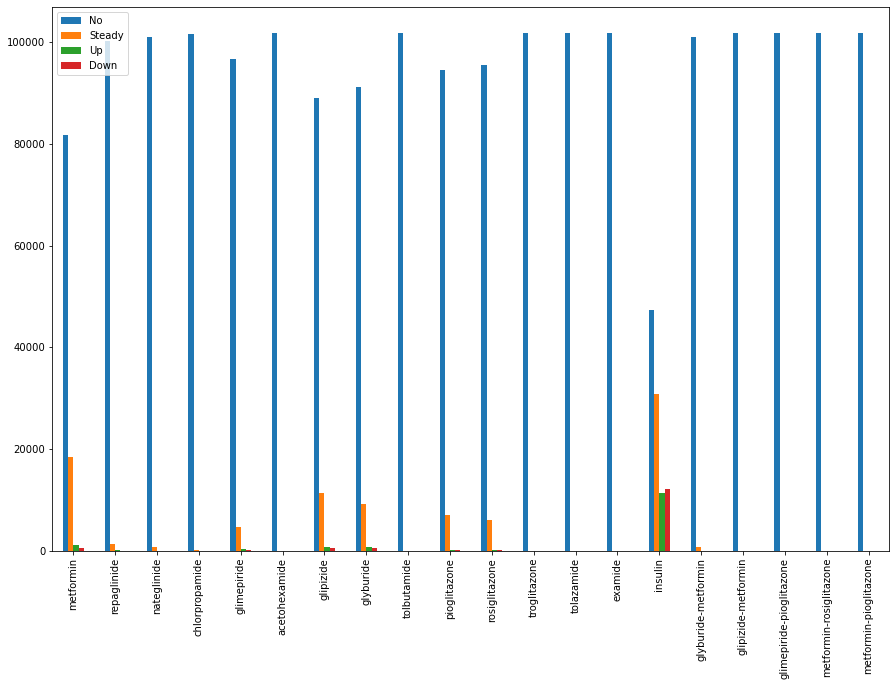

In [38]:
import re
import copy
all_cols = list(df.columns)
meds = pd.DataFrame()
i=0

#dummy = pd.DataFrame()
idx =  ['No','Steady', 'Up', 'Down']
cols = list()
dx = dict()

for e in all_cols:
    if e.endswith('de') or e.endswith('ne') or e.endswith('min') or e.endswith('lin'):
        ser = df[e].value_counts()
        dx[e] = copy.copy(dict(ser))
        
dummy = pd.DataFrame(dx)
dummy.T.plot.bar(logy=False,figsize=(15, 10))
       
        

### After viewing the plot above, we can see that most of the medicines have "No" as the  count which will not add any learning for modeling. <br> Only Insulin, pioglitazone, rosiglitazone, glipizide, glyburide, metformin have positive counts in other categories like Steady, Up and Down. <br> Only these medicine features will be included into modeling data


# Convert all the medication features, age, race, weight etc to one-hot encoding as below

In [39]:
import re
all_cols = list(df.columns)
meds = pd.DataFrame()
i=0
for e in all_cols:
    if e.endswith('insulin') or \
        e.endswith('race') or e.endswith('gender') or e.endswith('age') or e.endswith('medical_specialty') :
        dummy = pd.get_dummies(df[e], prefix=e)
        frames = [meds, dummy]
        meds = pd.concat(frames, axis=1)
    


In [40]:
len(df['number_outpatient'].unique())

39

In [41]:
df.age.unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [42]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

### Feature like time_in_hospital, num_lab_procedures, num_procedures, num_medications, <br>number_outpatient, number_emergency, number_inpatient are discrete values and they need to be standardized
       

In [43]:
norm_list=['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient']

norm_df = pd.DataFrame()
for n1 in norm_list:
    norm_df['norm_'+n1]=(df[n1]-df[n1].mean())/df[n1].std()

norm_df

,norm_time_in_hospital,norm_num_lab_procedures,norm_num_procedures,norm_num_medications,norm_number_outpatient,norm_number_emergency,norm_number_inpatient
0,-1.137643,-0.106516,-0.785394,-1.848259,-0.291460,-0.212619,-0.503274
1,-0.467650,0.808380,-0.785394,0.243388,-0.291460,-0.212619,-0.503274
2,-0.802647,-1.631343,2.145770,-0.371802,1.286742,-0.212619,0.288578
3,-0.802647,0.045966,-0.199161,-0.002688,-0.291460,-0.212619,-0.503274
4,-1.137643,0.401759,-0.785394,-0.986992,-0.291460,-0.212619,-0.503274
...,...,...,...,...,...,...,...
101761,-0.467650,0.401759,-0.785394,-0.002688,-0.291460,-0.212619,-0.503274
101762,0.202342,-0.513137,0.973305,0.243388,-0.291460,-0.212619,0.288578
101763,-1.137643,0.503414,-0.785394,-0.863954,0.497641,-0.212619,-0.503274
101764,1.877324,0.096794,0.387072,0.612503,-0.291460,-0.212619,0.288578


### There are many other features in the data which will not be considered now due to compute limitations. <br> The combined data of normalized discrete data and one-hot encoded categorical data will be included into modeling as shown below. 

In [44]:
frames = [meds, norm_df]
combined_df = pd.concat(frames, axis=1)
target = df.readmitted_binary

In [45]:
combined_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),medical_specialty_AllergyandImmunology,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Dermatology,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Neurophysiology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_Perinatology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Proctology,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Addictive,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Resident,medical_specialty_Rheumatology,medical_specialty_Speech,medical_specialty_SportsMedicine,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,medical_specialty_unknown,insulin_Down,insulin_No,insulin_Steady,insulin_Up,norm_time_in_hospital,norm_num_lab_procedures,norm_num_procedures,norm_num_medications,norm_number_outpatient,norm_number_emergency,norm_number_inpatient
0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1.137643,-0.106516,-0.785394,-1.848259,-0.291460,-0.212619,-0.503274
1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.467650,0.808380,-0.785394,0.243388,-0.291460,-0.212619,-0.503274
2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.802647,-1.631343,2.145770,-0.371802,1.286742,-0.212619,0.288578
3,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.8

In [46]:
# Count of readmitted vs not readmitted
Counter(target)

NameError: name 'Counter' is not defined

### The Data is imbalanced. There are more number of not readmitted examples than readmitted examples.<br> As seen above, there are only 11357 readmitted cases compared to 90409 not readmitted <br> SMOTE library will be used to rebalance the data

In [47]:
# Using Smote , lets rebalance the data
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(combined_df, target)

In [48]:
Counter(y)

NameError: name 'Counter' is not defined

### After rebalance , the readmitted and not readmitted are equal as seen above

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=42)

In [50]:
params = [
          ('lbfgs', 0.1,'l2'),
          ('lbfgs', 0.01,'l2'),
          ('liblinear', 0.1, 'l1'),
          ('liblinear', 0.01, 'l1')
         ]

saved_coef = dict()

for sol,reg_val,penalty in params:
    print("Solver {} Penalty {} strength {}".format(sol, penalty, reg_val))
    logreg = LogisticRegression(C=reg_val, penalty=penalty, solver=sol, max_iter=500)
    logreg.fit(X_train, y_train)
    print('coeff vals {}'.format(logreg.coef_[0:5]))
    saved_coef[(sol,reg_val,penalty)] = copy.deepcopy(logreg.coef_)
    scores = cross_val_score(logreg, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print('-'*30)
    

Solver lbfgs Penalty l2 strength 0.1
coeff vals [[-3.22056379 -3.58442216 -2.94255748 -3.90348149 -3.91398648 -3.52382778
  -3.50939587 -0.16614081 -3.58334019 -4.86532157 -3.87467645 -3.9672628
  -3.80678769 -3.65249787 -3.34567673 -3.20676346 -3.24189682 -3.64805016
  -0.16681829 -0.27251393 -0.56924195 -3.12660993 -0.23462639 -0.14966953
  -0.21079883 -0.08401836 -2.88382907 -2.51622297 -0.43696257 -2.69897536
  -3.26310484 -1.75571421 -1.55967809 -2.26341522 -1.5640022  -1.15700489
  -2.59656763 -2.78770302 -2.74249598 -0.088464   -1.08899478 -0.81884753
  -2.94161163 -2.72967749 -1.38261434 -2.72771356 -3.54999935 -1.43355085
  -2.46695809 -0.5373681  -0.87426276 -2.8881129  -0.14182655 -1.73218235
  -0.11326713 -2.35729393 -0.02750819 -0.05085531 -0.46291507 -0.62718171
  -0.07073208 -2.69408603 -0.63010963 -1.89113107 -0.08414038 -2.99392412
  -0.08932731 -0.38736665 -2.10730324 -3.33459354 -3.18686654 -1.36841174
  -0.06667314 -0.7790723   0.          0.         -1.35920192 -2.

In [51]:
import collections
dx = dict(zip( list(X.columns), list(saved_coef[('lbfgs',0.1,'l2')][0]) ))


In [52]:
sorted_values = sorted(dx.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in dx.keys():
        if dx[k] == i:
            sorted_dict[k] = dx[k]
            break

sorted_dict

{'age_[10-20)': -4.8653215733864155,
 'insulin_Up': -3.98648486553655,
 'age_[30-40)': -3.967262795178731,
 'race_Other': -3.913986481432106,
 'race_Hispanic': -3.90348148825067,
 'age_[20-30)': -3.87467644765166,
 'insulin_Down': -3.8296613077160773,
 'insulin_Steady': -3.8205378805714565,
 'age_[40-50)': -3.806787687793318,
 'insulin_No': -3.802158727899761,
 'age_[50-60)': -3.65249787390512,
 'age_[90-100)': -3.6480501604211666,
 'race_Asian': -3.5844221638947977,
 'age_[0-10)': -3.583340185613791,
 'medical_specialty_Orthopedics-Reconstructive': -3.549999347367005,
 'gender_Female': -3.5238277827156024,
 'gender_Male': -3.509395873438974,
 'medical_specialty_Surgery-Cardiovascular/Thoracic': -3.442778131955044,
 'age_[60-70)': -3.3456767288042286,
 'medical_specialty_Pulmonology': -3.3345935448670594,
 'medical_specialty_Gastroenterology': -3.263104839216236,
 'age_[80-90)': -3.241896817796296,
 'race_AfricanAmerican': -3.220563793095565,
 'age_[70-80)': -3.2067634645487093,
 'medi

## The most significant feature in terms of readmittance with in 30 days is Number_inpatient.<br> The least significant is age between 10 to 20.

In [53]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [54]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,7789,6485,14274
1,995,880,1875
All,8784,7365,16149


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.88
Precision is 0.91
Recall is 0.84


                       Feature  Importance
93              insulin_Steady    0.007164
15                 age_[70-80)    0.007353
90   medical_specialty_unknown    0.007641
100      norm_number_emergency    0.014854
99      norm_number_outpatient    0.025276
97         norm_num_procedures    0.061692
96     norm_num_lab_procedures    0.073861
98        norm_num_medications    0.112108
101      norm_number_inpatient    0.207842
95       norm_time_in_hospital    0.384565


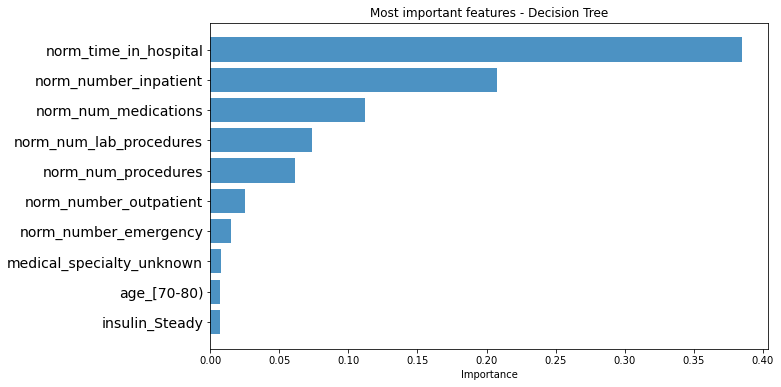

In [56]:
import matplotlib.pyplot as plt
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [58]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8144,6130,14274
1,1047,828,1875
All,9191,6958,16149


In [59]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.85
Precision is 0.91
Recall is 0.79


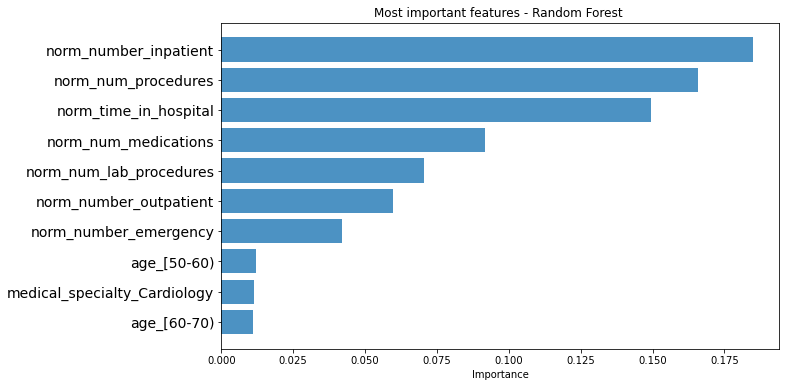

In [60]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

<ipython-input-63-0145096663a9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)
<ipython-input-63-0145096663a9>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


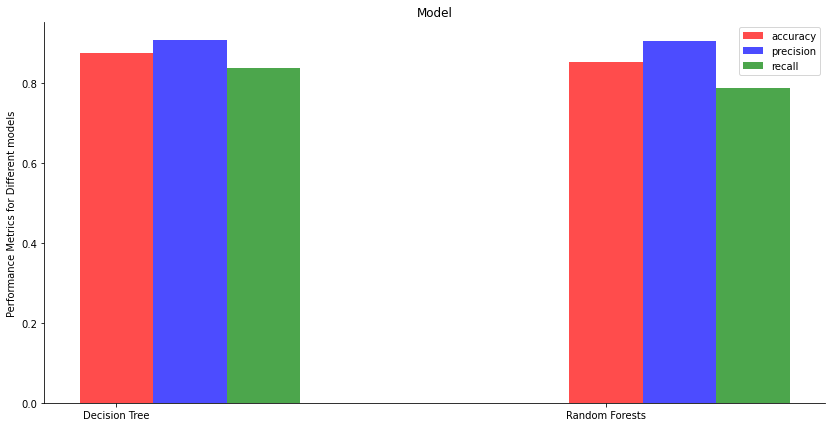

In [63]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests']
values = [accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests']
values = [precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests' ]
values = [recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()   